In [1]:
!pip install openpyxl

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 250.9/250.9 kB 4.1 MB/s eta 0:00:00


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel, Matern, WhiteKernel
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score

In [4]:
# Load the dataset from the Excel file
file_path = "/content/Dataset.xlsx"
# Read the first sheet of the Excel file
df = pd.read_excel(file_path, sheet_name=0)
# Display the first few rows to understand the structure
df.head()

,Al,Ni,Cr,Fe,Co,Y/ρ
0,5.915671,38.260765,15.066780,18.208058,22.548726,15.145846
1,6.723904,32.963827,17.632538,10.268567,32.411163,14.908428
2,7.572302,27.576237,31.674493,5.144472,28.032495,14.784499
3,8.364993,36.800155,23.077290,17.699946,14.057617,14.603801
4,9.434940,31.589300,22.932410,20.511939,15.531411,13.606427


In [5]:
# Define features (X) and targets (Y1 for E, Y2 for rho)
X = df[['Al', 'Ni', 'Cr', 'Fe', 'Co']]
y = df['Y/ρ']

In [6]:
# prompt: Concatenate X and y

import pandas as pd
# Concatenate X and y along columns (axis=1)
Xy = pd.concat([X, y], axis=1)

# Display the first few rows of the concatenated DataFrame
print(Xy.head())


         Al         Ni         Cr         Fe         Co        Y/ρ
0  5.915671  38.260765  15.066780  18.208058  22.548726  15.145846
1  6.723904  32.963827  17.632538  10.268567  32.411163  14.908428
2  7.572302  27.576237  31.674493   5.144472  28.032495  14.784499
3  8.364993  36.800155  23.077290  17.699946  14.057617  14.603801
4  9.434940  31.589300  22.932410  20.511939  15.531411  13.606427


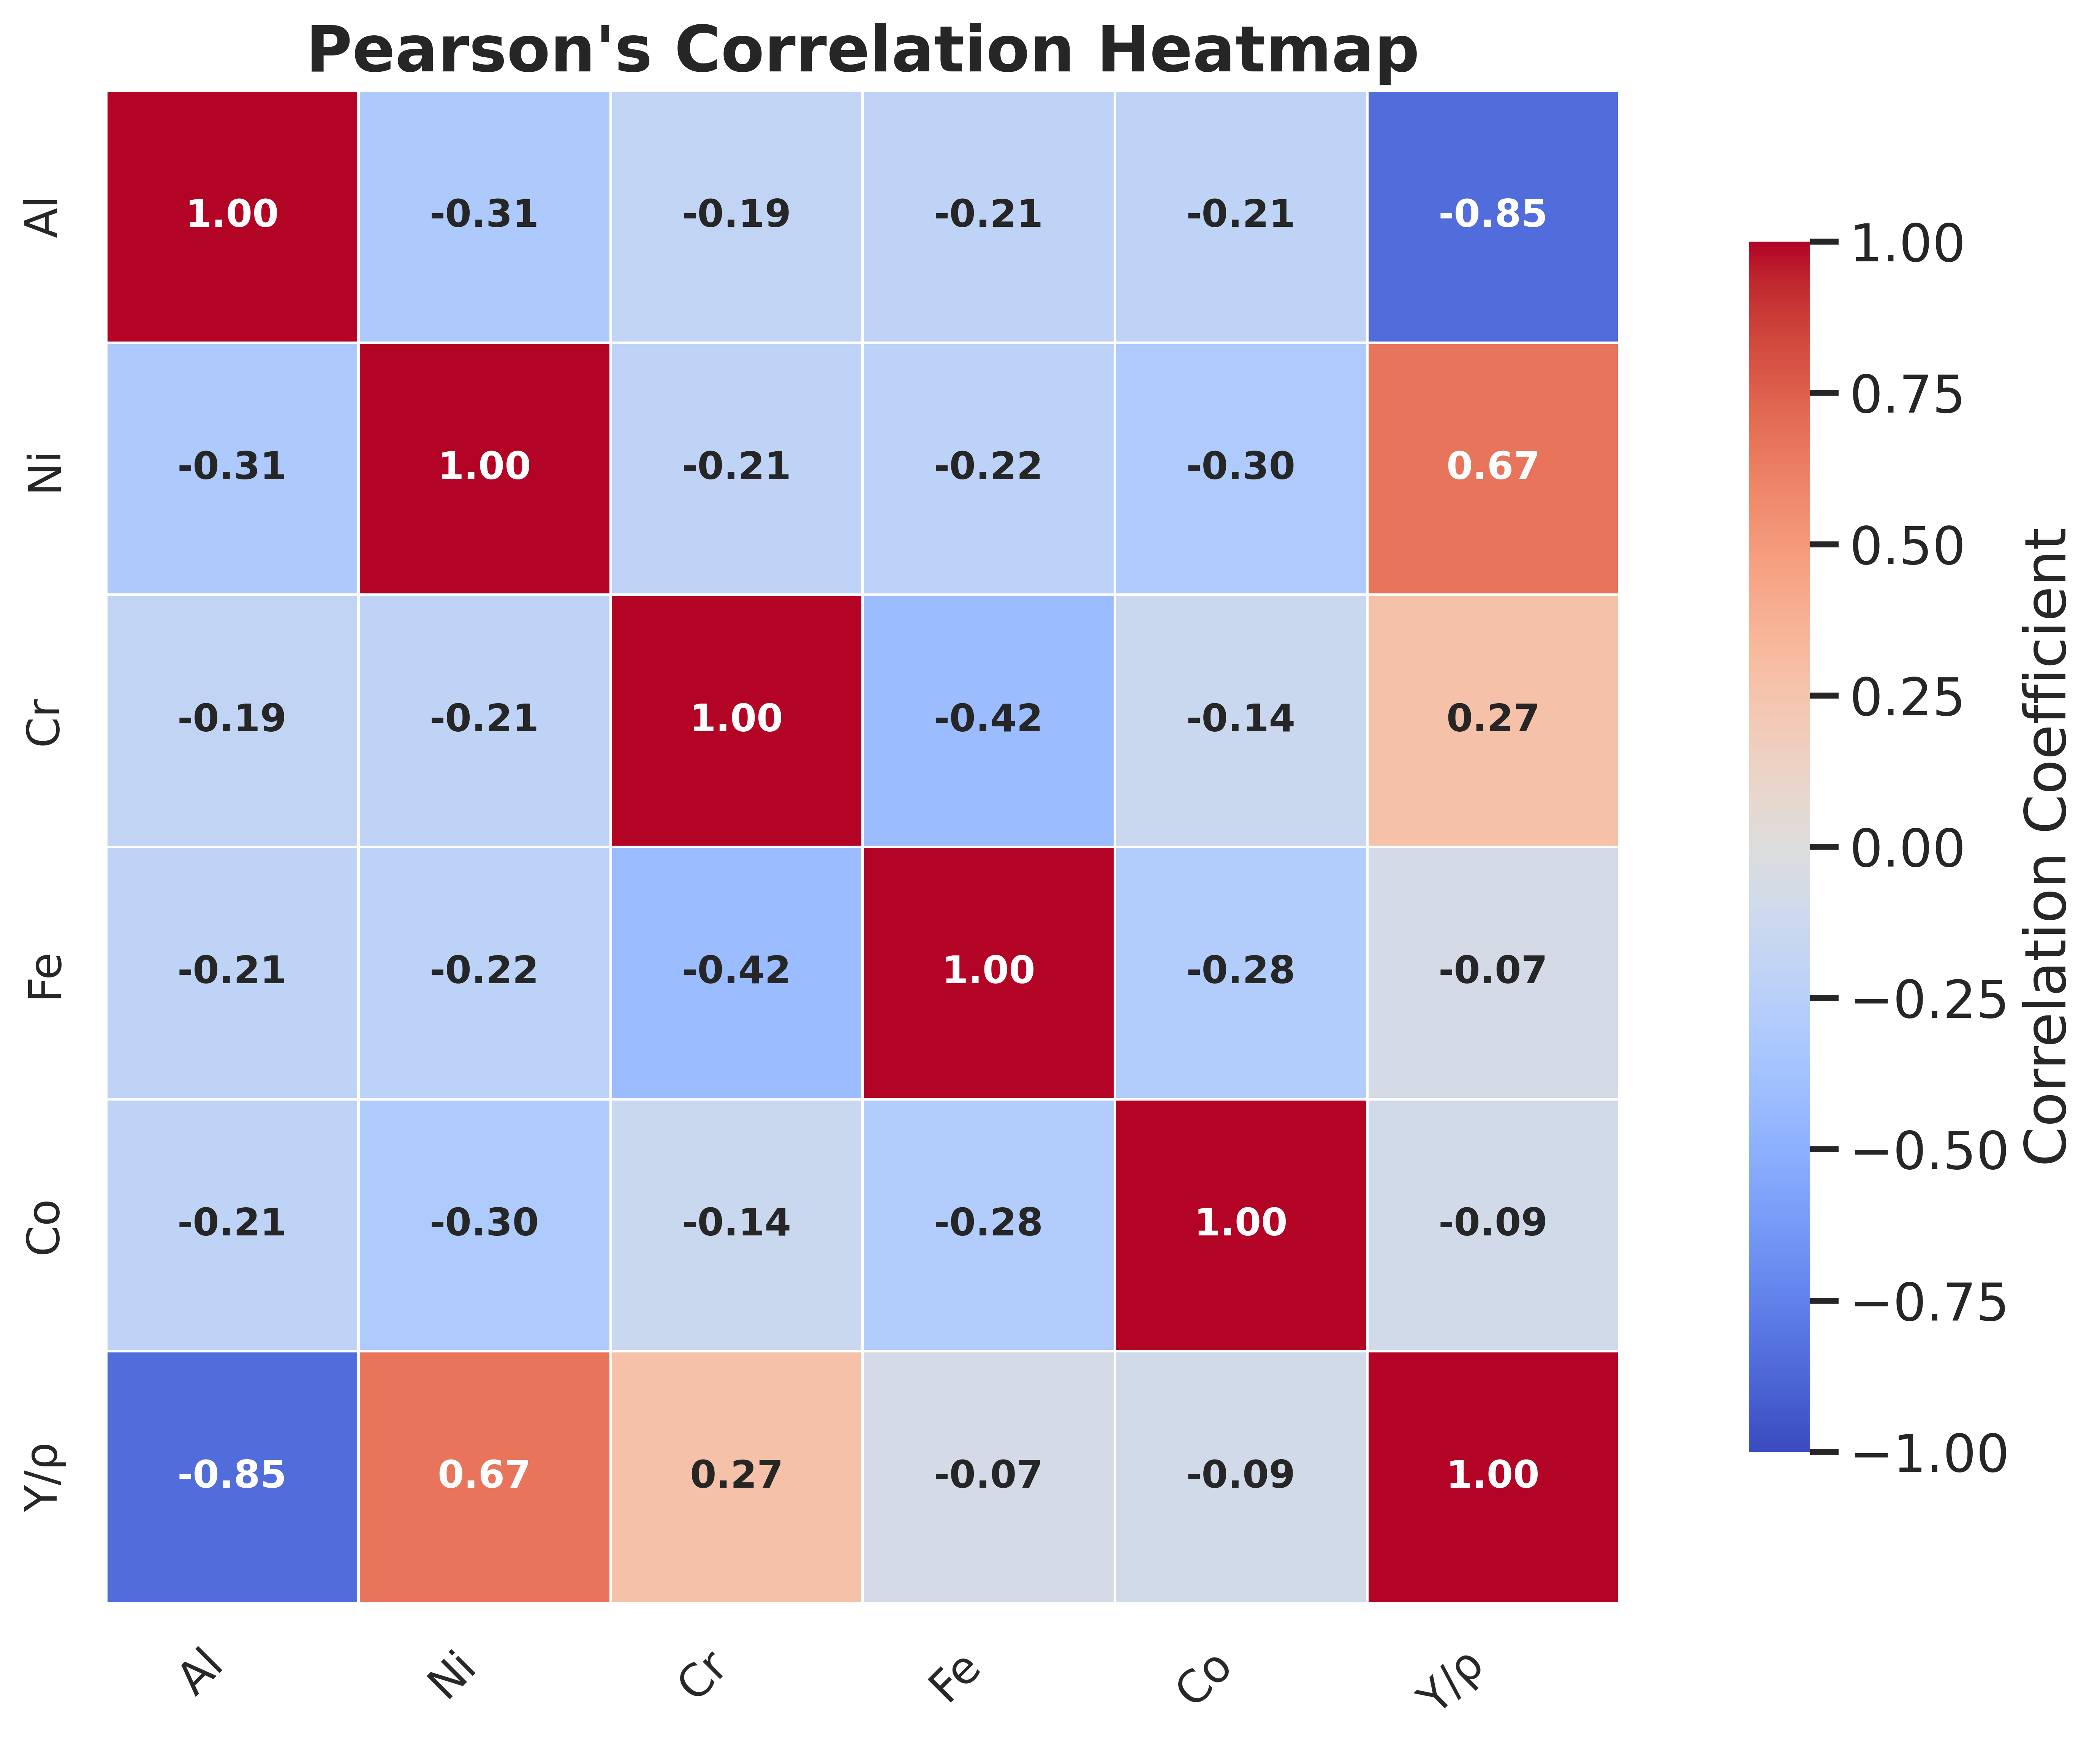

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt

# Set Seaborn style for clean, publication-ready visuals
sns.set(style='white', context='talk', palette='muted')

# Create the figure with high DPI for clarity
plt.figure(figsize=(12, 8), dpi=600)

# Calculate the Pearson correlation matrix
corr_matrix = Xy.corr()

# Create the heatmap with improvements
sns.heatmap(
    corr_matrix,
    annot=True,
    cmap='coolwarm',  # Use 'coolwarm' for better contrast and readability
    fmt='.2f',
    linewidths=0.8,
    cbar_kws={'shrink': 0.8, 'label': 'Correlation Coefficient'},
    vmax=1.0,
    vmin=-1.0,
    annot_kws={'size': 12, 'weight': 'bold'},  # Adjust annotation size and weight for visibility
    square=True,  # Makes the heatmap square for a more balanced appearance
)

# Add title and adjust fonts for professional presentation
plt.title("Pearson's Correlation Heatmap", fontsize=20, fontweight='bold')

# Customize tick labels for better readability
plt.xticks(fontsize=14, rotation=45, ha='right')
plt.yticks(fontsize=14)

# Add gridlines subtly for context
plt.grid(True, which='both', axis='both', linestyle='--', linewidth=0.5, alpha=0.3)

# Save the figure with transparent background and high resolution for publication use
plt.tight_layout()
plt.savefig("Pearson_correlation_heatmap_elegant.png", dpi=600, bbox_inches='tight', transparent=True)

# Show the plot
plt.show()


In [8]:
# Split data into training and testing sets (90% train, 10% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

In [9]:
from sklearn.preprocessing import StandardScaler
# Create an instance of StandardScaler
scaler = StandardScaler()

# Transform input features
X_train_transformed = scaler.fit_transform(X_train) # Call fit_transform on the scaler instance
X_test_transformed = scaler.transform(X_test) # Call transform on the scaler instance

In [10]:
# Define a function to train and tune a GPR model
def train_gpr(X_train, Y_train):
    # Define a pipeline with feature scaling and GPR
    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('gpr', GaussianProcessRegressor())
    ])

    # Define the hyperparameter grid
    param_grid = {
        'gpr__kernel': [
            ConstantKernel(1.0) * RBF(length_scale=1.0),
            ConstantKernel(1.0) * Matern(length_scale=1.0, nu=1.5),
            ConstantKernel(1.0) * RBF(length_scale=1.0) + WhiteKernel(noise_level=1e-5)
        ],
        'gpr__alpha': [1e-10, 1e-5, 1e-2]
    }

    # Perform grid search with cross-validation
    grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
    grid_search.fit(X_train, Y_train)

    return grid_search.best_estimator_, grid_search.best_params_

In [11]:
# Train and tune the GPR models
best_gpr, best_params = train_gpr(X_train_transformed, y_train)

In [12]:
# Cross-validation scores
cv_scores_GPR = cross_val_score(best_gpr, X_train, y_train.values.ravel(), cv=5, scoring='r2')

print("Best GPR parameters:", best_params)
print("GPR 5-fold CV R2 scores:", cv_scores_GPR)

Best GPR parameters: {'gpr__alpha': 1e-05, 'gpr__kernel': 1**2 * Matern(length_scale=1, nu=1.5)}
GPR 5-fold CV R2 scores: [0.99111538 0.98083893 0.99929215 0.98499932 0.99658778]


In [13]:
# Predictions
y_train_pred = best_gpr.predict(X_train_transformed)
y_test_pred = best_gpr.predict(X_test_transformed)

# Evaluation
r2_train = r2_score(y_train, y_train_pred)
r2_test = r2_score(y_test, y_test_pred)
mse_train = mean_squared_error(y_train, y_train_pred)
mse_test = mean_squared_error(y_test, y_test_pred)

print("GPR R-squared (Train, Test):", r2_train, r2_test)
print("GPR MSE (Train, Test):", mse_train, mse_test)

GPR R-squared (Train, Test): 0.9999999988105388 0.9909342902391642
GPR MSE (Train, Test): 7.81255340525799e-09 0.04817679957420504


<ipython-input-14-d4cb12445c4a>:27: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Dataset', y='Relative Percentage Error (%)', data=relative_error_df, width=0.5, palette='Set2', ax=axes[1])


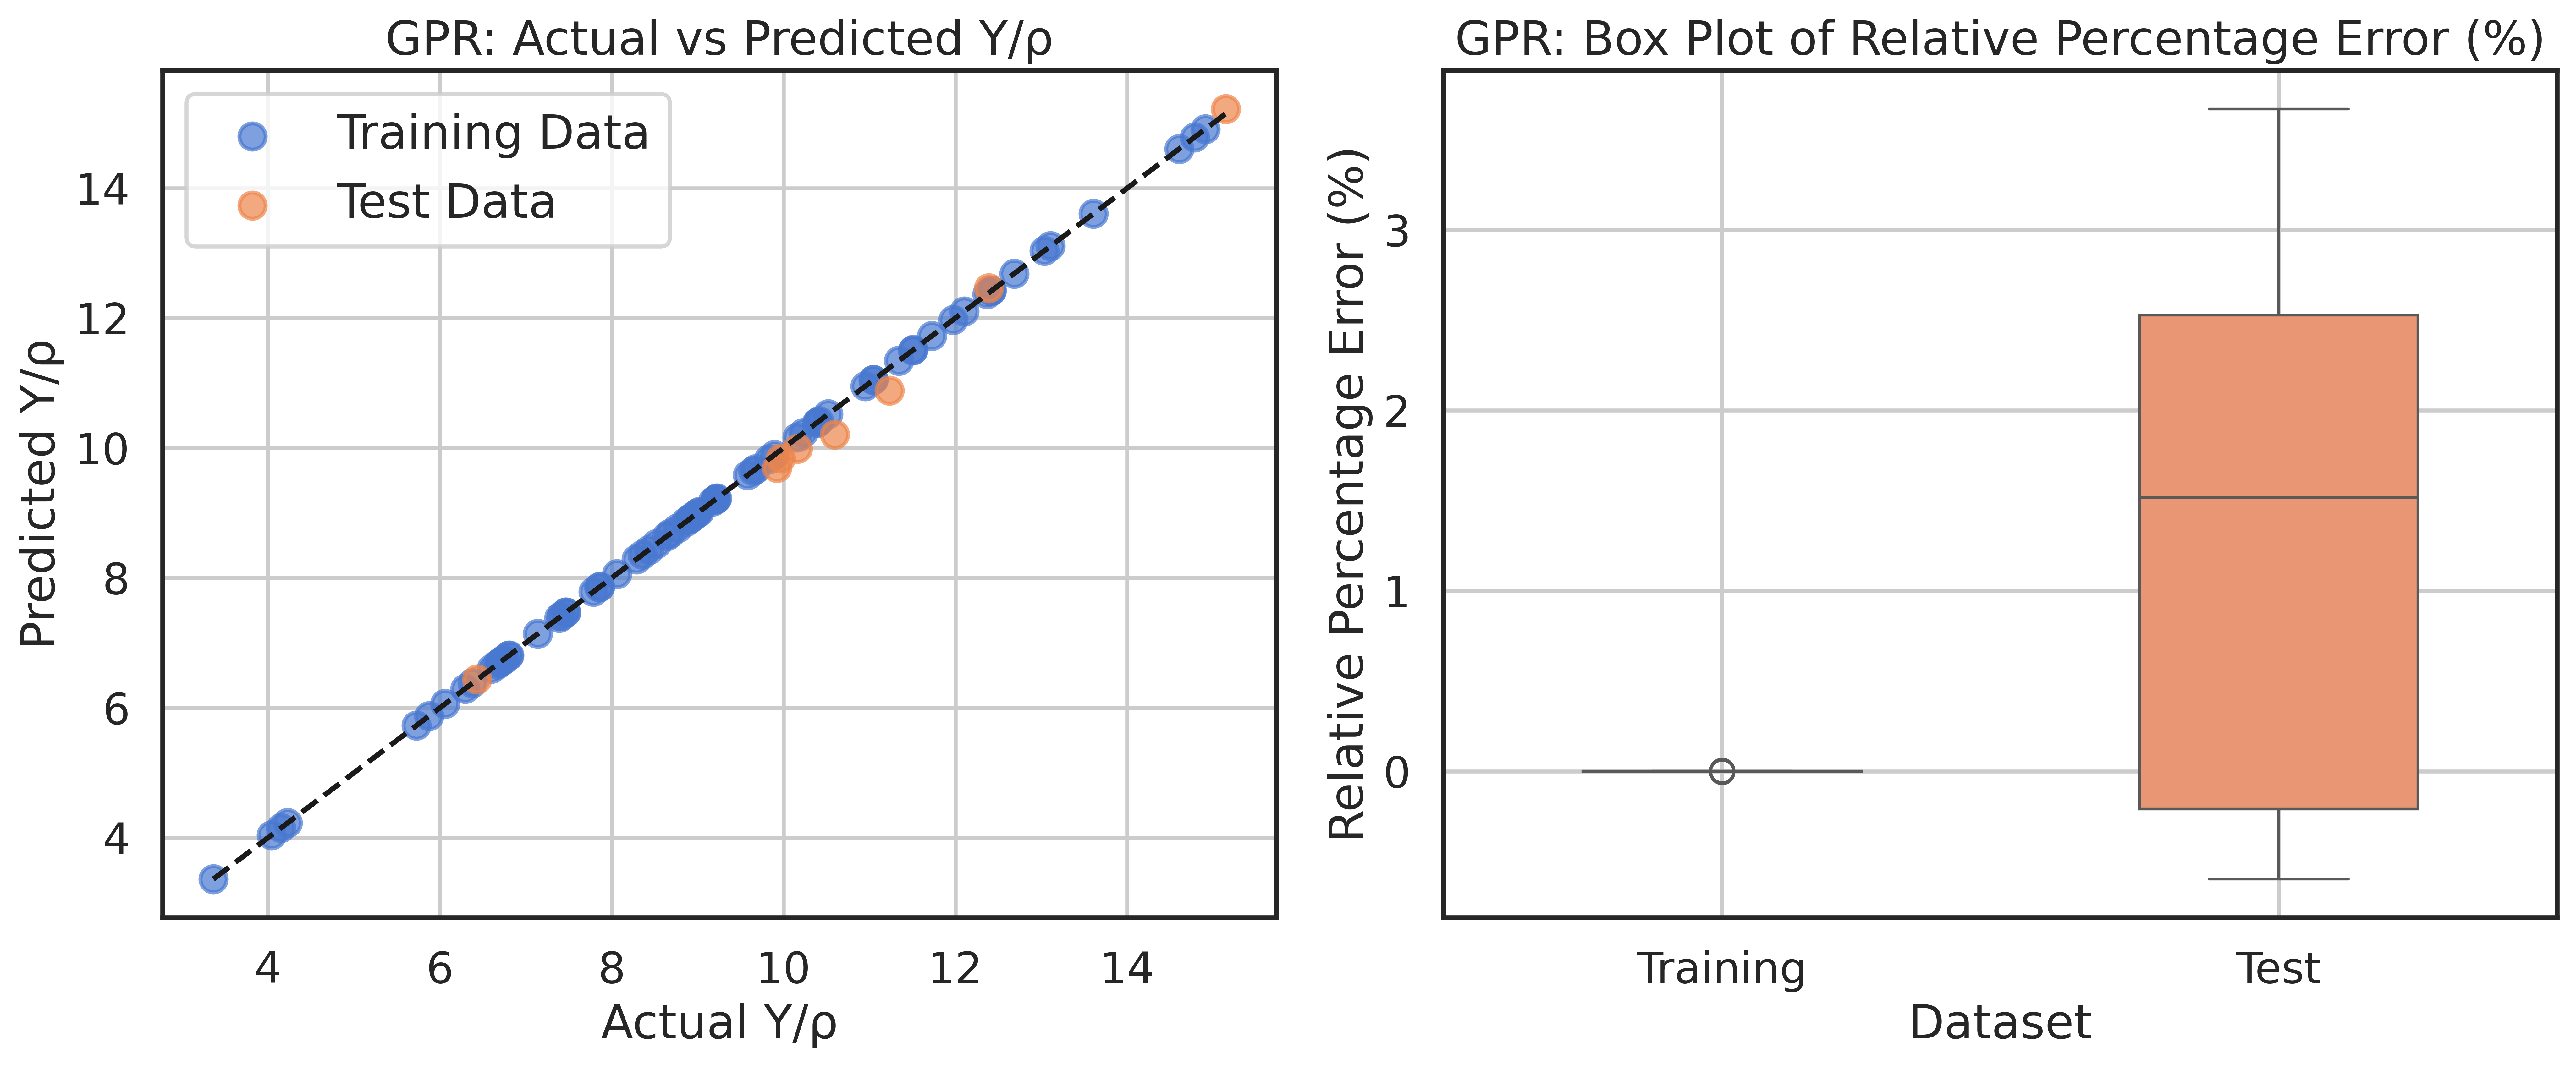

In [14]:
# High-quality GPR Regressor plots
fig, axes = plt.subplots(1, 2, figsize=(14, 6), dpi=600)

# --- (1) Actual vs Predicted Scatter Plot ---
axes[0].scatter(y_train, y_train_pred, label='Training Data', alpha=0.7, s=100)
axes[0].scatter(y_test, y_test_pred, label='Test Data', alpha=0.7, s=100)
axes[0].plot([min(y_train.min(), y_test.min()), max(y_train.max(), y_test.max())],
             [min(y_train.min(), y_test.min()), max(y_train.max(), y_test.max())],
             'k--', linewidth=2)  # 45-degree reference line
axes[0].set_xlabel('Actual Y/ρ', fontsize=18)
axes[0].set_ylabel('Predicted Y/ρ', fontsize=18)
axes[0].set_title('GPR: Actual vs Predicted Y/ρ', fontsize=18)
axes[0].legend(fontsize=18)
axes[0].grid(True)

# --- (2) Probability Density of Sample-wise Relative Percentage Errors ---
relative_error_train = (y_train - y_train_pred) * 100 / y_train
relative_error_test = (y_test - y_test_pred) * 100 / y_test

# Combine errors into a DataFrame
relative_error_df = pd.DataFrame({
    'Relative Percentage Error (%)': np.concatenate([relative_error_train, relative_error_test]),
    'Dataset': ['Training'] * len(relative_error_train) + ['Test'] * len(relative_error_test)
})

# Boxplot
sns.boxplot(x='Dataset', y='Relative Percentage Error (%)', data=relative_error_df, width=0.5, palette='Set2', ax=axes[1])

axes[1].set_xlabel('Dataset', fontsize=18)
axes[1].set_ylabel('Relative Percentage Error (%)', fontsize=18)
axes[1].set_title('GPR: Box Plot of Relative Percentage Error (%)', fontsize=18)
axes[1].grid(True)

# --- Save and Show ---
plt.savefig("GPR_absolute_error_PDF.png", dpi=300, bbox_inches='tight')
plt.tight_layout()
plt.show()

<ipython-input-15-5ee427d5ec30>:41: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Dataset', y='Relative Percentage Error (%)', data=relative_error_df, width=0.4, palette='Set2', ax=axes[1])


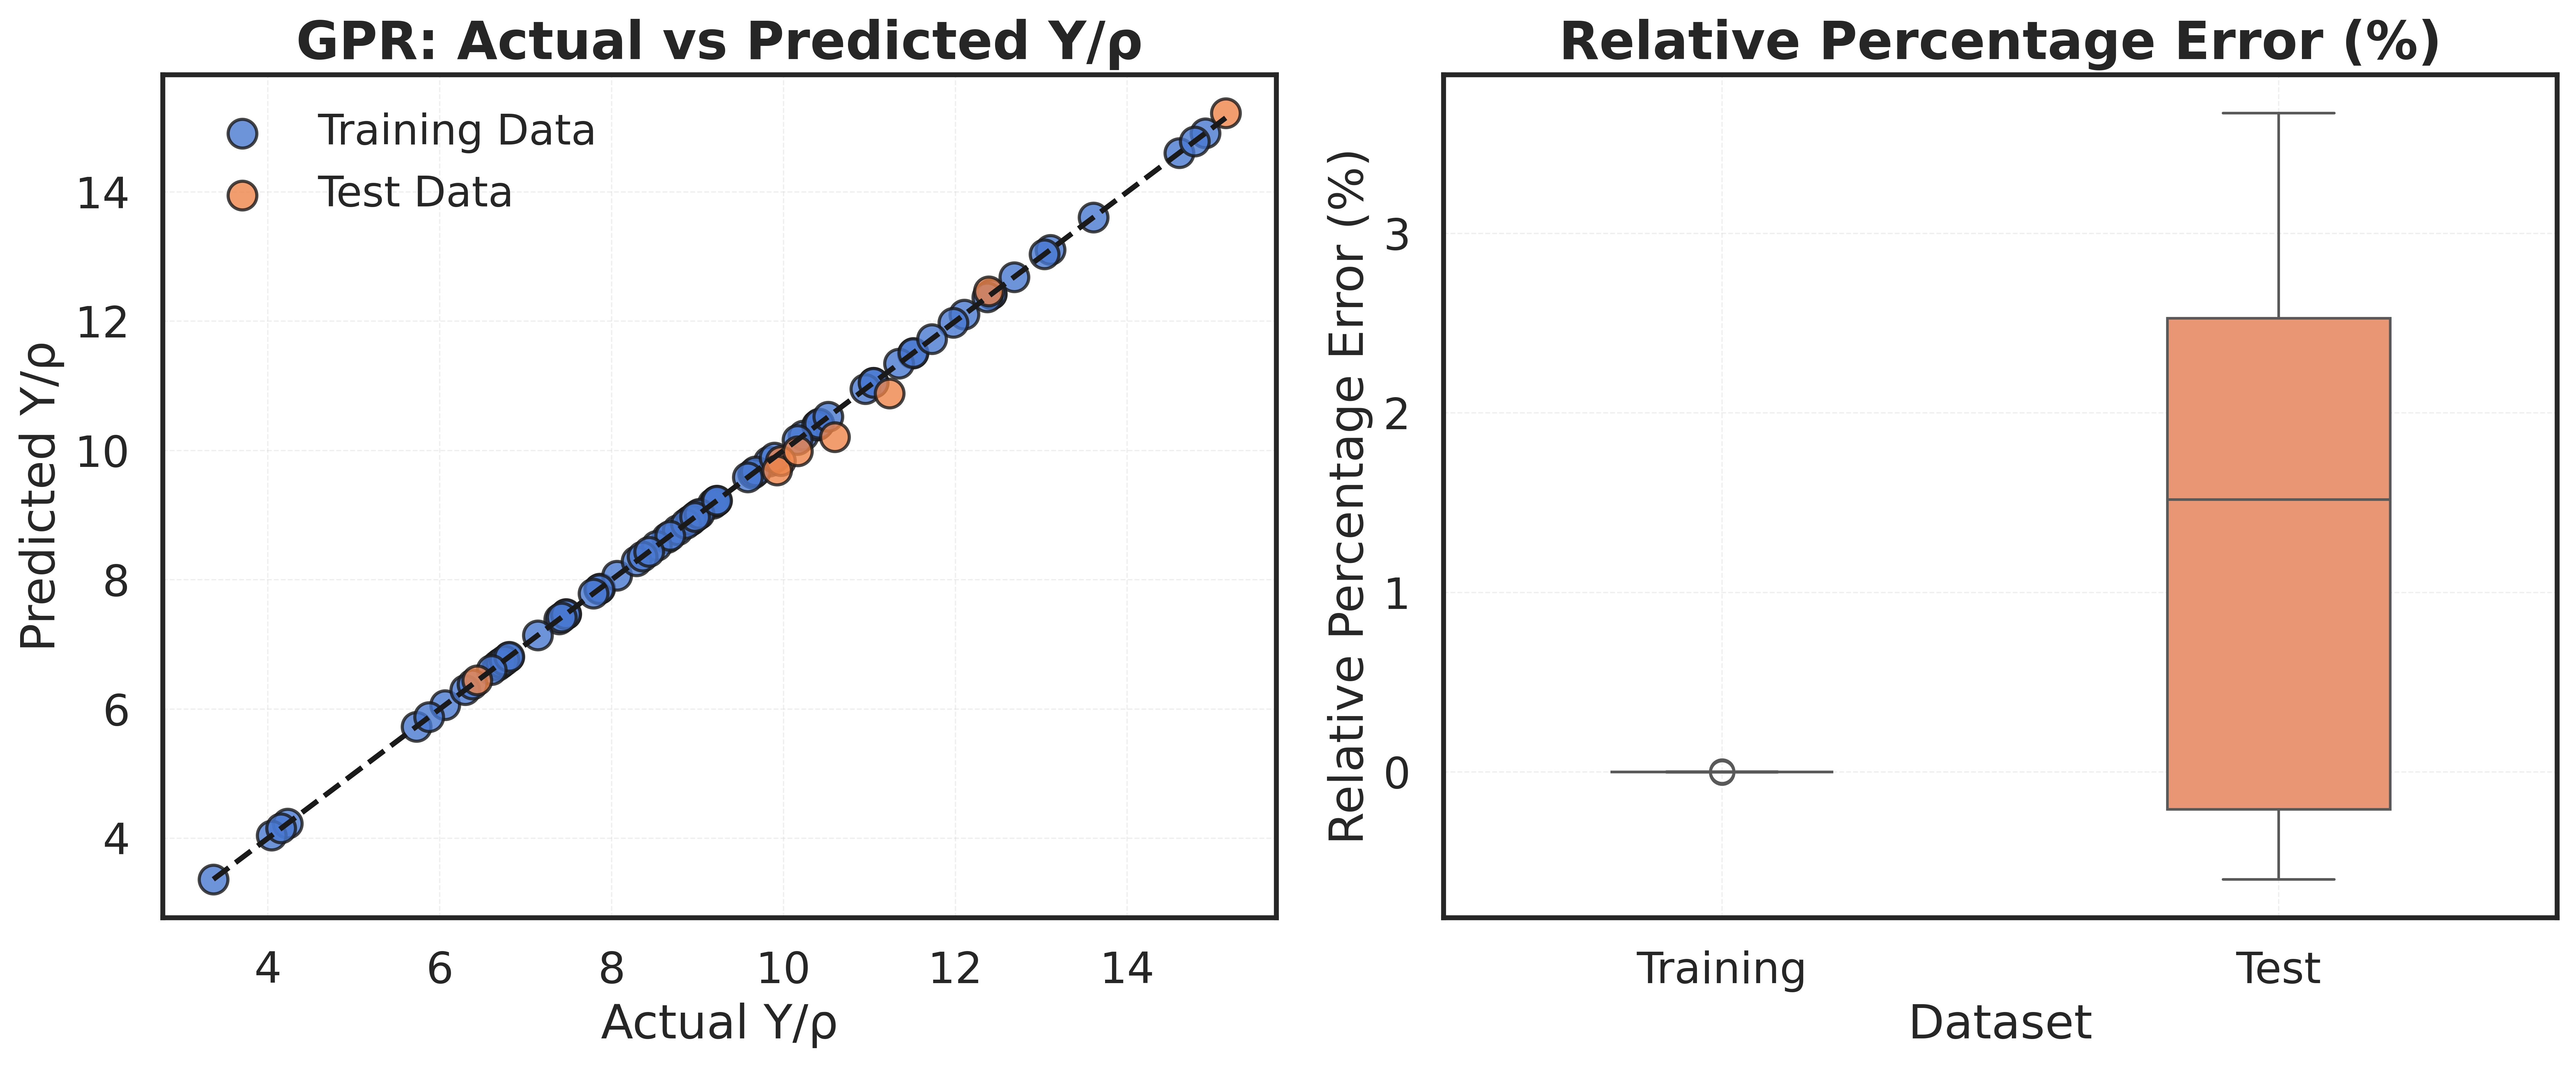

In [15]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Set Seaborn style for publication-ready visuals
sns.set(style='white', context='talk', palette='muted')

# Create the figure with two subplots (side-by-side)
fig, axes = plt.subplots(1, 2, figsize=(14, 6), dpi=600)

# --- (1) Actual vs Predicted Scatter Plot ---
axes[0].scatter(y_train, y_train_pred, label='Training Data', alpha=0.8, s=120, edgecolors='k', linewidth=1.2)
axes[0].scatter(y_test, y_test_pred, label='Test Data', alpha=0.8, s=120, edgecolors='k', linewidth=1.2)

# Add the 45-degree reference line
axes[0].plot([min(y_train.min(), y_test.min()), max(y_train.max(), y_test.max())],
             [min(y_train.min(), y_test.min()), max(y_train.max(), y_test.max())],
             'k--', linewidth=2)

# Titles and Labels
axes[0].set_xlabel('Actual Y/ρ', fontsize=18)
axes[0].set_ylabel('Predicted Y/ρ', fontsize=18)
axes[0].set_title('GPR: Actual vs Predicted Y/ρ', fontsize=20, weight='bold')

# Customize legend and grid
axes[0].legend(fontsize=16, loc='upper left', frameon=False)
axes[0].grid(True, linestyle='--', linewidth=0.5, alpha=0.3)

# --- (2) Probability Density of Sample-wise Relative Percentage Errors ---
relative_error_train = (y_train - y_train_pred) * 100 / y_train
relative_error_test = (y_test - y_test_pred) * 100 / y_test

# Combine errors into a DataFrame for the boxplot
relative_error_df = pd.DataFrame({
    'Relative Percentage Error (%)': np.concatenate([relative_error_train, relative_error_test]),
    'Dataset': ['Training'] * len(relative_error_train) + ['Test'] * len(relative_error_test)
})

# Boxplot with enhanced style
sns.boxplot(x='Dataset', y='Relative Percentage Error (%)', data=relative_error_df, width=0.4, palette='Set2', ax=axes[1])

# Titles and Labels for the boxplot
axes[1].set_xlabel('Dataset', fontsize=18)
axes[1].set_ylabel('Relative Percentage Error (%)', fontsize=18)
axes[1].set_title('Relative Percentage Error (%)', fontsize=20, weight='bold')

# Customize grid
axes[1].grid(True, linestyle='--', linewidth=0.5, alpha=0.3)

# Adjust layout for better spacing
plt.tight_layout()

# Save the figure with high quality and transparent background
plt.savefig("GPR_validation_elegant.png", dpi=600, bbox_inches='tight', transparent=True)

# Show plot
plt.show()

In [16]:
import numpy as np
import pandas as pd

# Set random seed for reproducibility
np.random.seed(42)

# Define element names
elements = ['Al', 'Ni', 'Cr', 'Fe', 'Co']

# Define bounds
lower_bound = 5
upper_bound = 35
num_samples = 1000  # Number of random samples

# Generate compositions with sum = 100
samples = []
for _ in range(num_samples):
    while True:
        rand_vals = np.random.uniform(lower_bound, upper_bound, len(elements))  # Random values
        scale_factor = 100 / np.sum(rand_vals)  # Scale to sum to 100
        scaled_vals = rand_vals * scale_factor  # Adjust values

        # Ensure all values remain within [5, 35]
        if np.all(scaled_vals >= lower_bound) and np.all(scaled_vals <= upper_bound):
            samples.append(scaled_vals)
            break

# Convert to DataFrame
df_unknown = pd.DataFrame(samples, columns=elements)

# Display first few rows
print(df_unknown.head())

          Al         Ni         Cr         Fe         Co
0  14.846869  30.652994  24.652861  20.995084   8.852192
1  10.011905   6.973812  32.048243  23.823619  27.142422
2  13.627223  18.331074  26.915031  23.302160  17.824513
3  28.841999  11.342402  16.997692  19.747234  23.070673
4  32.034740  12.329371  22.916068  25.547259   7.172562


In [17]:
#Normalizing df_unknown
X_train_all = np.concatenate((X_train,X_test),axis = 0)
y_train_all = np.concatenate((y_train,y_test),axis=0)

In [18]:
scaler = StandardScaler()
X_train_all_scaled = scaler.fit_transform(X_train_all) ## fit and transform training data and
X_unknown_scaled  = scaler.transform(df_unknown) # transform test data
print('maximum value of the UTS in the experimental data:',y_train_all.max())

maximum value of the UTS in the experimental data: 15.145846204110693


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


In [19]:
import numpy as np
from scipy.stats import norm
def bootstrap_estimator(model, X_train, y_train, X_test, n_iter=100):
  bootstrap_preds = np.zeros([len(X_test), n_iter])
  index = np.arange(X_train.shape[0])
  np.random.seed(20)  # Fix seed for reproducibility
  for i in range(n_iter):
      index_sampled = np.random.choice(index, size=X_train.shape[0], replace=True)
        # Add small Gaussian noise to prevent identical predictions
        # Use array indexing instead of .iloc
      X_train_sample = X_train[index_sampled, :] + np.random.normal(0, 0.01, X_train.shape)
      y_train_sample = np.array(y_train)[index_sampled].reshape(-1, 1)
      model.fit(X_train_sample, y_train_sample.ravel())
      bootstrap_preds[:, i] = model.predict(X_test)
  return bootstrap_preds.mean(1), bootstrap_preds.std(1)
 # Expected Improvement function
def Expected_Improvement(X_test, X_train_all, y_train_all, model, xi=0.1):
  mu_x, sigma_x = bootstrap_estimator(model, X_train_all, y_train_all, X_test, n_iter=10000)
  epsilon = 1e-6  # Small offset to prevent division by zero
  sigma_x = np.where(sigma_x == 0, epsilon, sigma_x)
  mu_max = np.percentile(y_train_all, 95)  # Use 95th percentile instead of max
  diff = mu_x - mu_max - xi
  z = diff / sigma_x
  ei = np.where(sigma_x > 0, diff * norm.cdf(z) + sigma_x * norm.pdf(z), 0)
  return ei, mu_x, sigma_x

In [ ]:
# Run EI calculation
ei, predicted_property, std = Expected_Improvement(X_unknown_scaled, X_train_all_scaled, y_train_all, best_gpr, xi=0.1)

/usr/local/lib/python3.11/dist-packages/sklearn/gaussian_process/_gpr.py:660: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/usr/local/lib/python3.11/dist-packages/sklearn/gaussian_process/_gpr.py:660: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/usr/local/lib/python3.11/dist-packages/sklearn/gaussian_process/_gpr.py:660: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessin

In [ ]:
# Create DataFrame
df_predict = pd.DataFrame({"ei": ei, "predicted_property": predicted_property, "std": std})

In [ ]:
# Save to CSV
df_predict.to_csv('ei_scores.csv', index=False)

In [ ]:
# Concatenate df_unknown and df_predict
df_concatenated = pd.concat([df_unknown, df_predict], axis=1)

# Display the first few rows of the concatenated DataFrame
#print(df_concatenated.head())

# Save the concatenated DataFrame to a CSV file (optional)
#df_concatenated.to_csv('concatenated_data.csv', index=False)


In [ ]:
# Sort results
df_predict_final_sorted = df_concatenated.sort_values('ei', ascending=False)
df_predict_final_sorted.to_csv('/content/ei_sorted.csv')

In [ ]:
# Display top results
print(df_predict_final_sorted.head(10))

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler

# Data for maximum Young's modulus (maximum density too, which we want to minimize)
max_y_MD = np.array([
    [5.91567079, 38.26076527, 15.06678021, 18.20805762, 22.54872611],
    [6.72390408, 32.96382729, 17.63253827, 10.26856727, 32.41116309],
    [7.57230249, 27.57623741, 31.67449300, 5.14447224, 28.03249486],
    [8.36499270, 36.80015459, 23.07729033, 17.69994552, 14.05761686],
    [9.43493974, 31.58929951, 22.93241049, 20.51193922, 15.53141104]
])
min_y_MD = np.array([
    [26.24770646, 10.92551999, 15.24550638, 23.48588964, 24.09537753],
    [32.91217864, 5.64977420, 28.22405144, 14.32021921, 18.89377651],
    [26.63869322, 5.32443020, 8.26732145, 31.12024700, 28.64930813],
    [32.80395217, 9.93076823, 7.22004033, 25.42345776, 24.62178151],
    [27.83319605, 5.76794486, 21.56151645, 15.64621880, 29.19112384]
])

# Updated tradeoff solutions (5-dimensional vectors as per clarification)
BO_solutions = np.array([
    [6.692035871, 33.00979578, 31.84161268, 7.885999528, 20.57055615],
    [6.327502576, 29.6771072, 24.40845823, 7.63143682, 31.95549517],
    [7.29356089, 33.46886366, 24.21908298, 13.1425768, 21.87591567],
    [8.801980245, 33.56545629, 28.94356638, 9.432952926, 19.25604416],
    [7.298468997, 32.99123061, 30.630777, 13.13004826, 15.94947513],
    [8.068488636, 29.87560705, 32.11593917, 11.03504576, 18.90491939],
    [7.263615891, 33.30826105, 15.62263821, 15.51784039, 28.28764446],
    [10.395278, 30.93675941, 29.76802481, 5.523410573, 23.37652721],
    [7.209259621, 24.13100334, 33.8170803, 10.24507983, 24.59757692],
    [6.809851918, 31.21118436, 18.27812425, 20.12421111, 23.57662836]
])

# Combine all the data into one dataset
all_data = np.vstack([max_y_MD, min_y_MD, BO_solutions])

# Normalize the data using StandardScaler
scaler = StandardScaler()
all_data_scaled = scaler.fit_transform(all_data)

# Apply t-SNE with a lower perplexity value
tsne = TSNE(n_components=2, perplexity=8, random_state=42)
tsne_results = tsne.fit_transform(all_data_scaled)

# Prepare labels for each group for better visualization
labels = ['max_y_MD'] * len(max_y_MD) + \
         ['min_y_MD'] * len(max_y_MD) + \
         ['BO_solutions'] * len(BO_solutions)

# Create a DataFrame for better handling of the data
tsne_df = pd.DataFrame(tsne_results, columns=['TSNE1', 'TSNE2'])
tsne_df['Label'] = labels

# Plot the t-SNE result
plt.figure(figsize=(10, 8), dpi=300)  # Set figure size and DPI for high-quality output
scatter = plt.scatter(tsne_df['TSNE1'], tsne_df['TSNE2'], c=pd.Categorical(tsne_df['Label']).codes, cmap='viridis', s=100, alpha=0.7)

# Add title and labels with larger font sizes for readability
plt.title('t-SNE of Solutions for Multi-Objective Optimization', fontsize=16)
plt.xlabel('t-SNE Component 1', fontsize=14)
plt.ylabel('t-SNE Component 2', fontsize=14)

# Add a legend with larger font size
plt.legend(handles=scatter.legend_elements()[0], labels=sorted(tsne_df['Label'].unique()), fontsize=12)

# Save the figure with a high resolution (300 DPI)
plt.savefig('tsne_plot_high_quality.png', format='png', dpi=300)

# Show plot
plt.show()

In [ ]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

# Set Seaborn style for publication-ready visuals
sns.set(style='white', context='talk', palette='muted')

# Create the figure
fig, ax = plt.subplots(figsize=(10, 8), dpi=600)  # High DPI for sharpness

# Use Seaborn's scatterplot with automatic legend
sns.scatterplot(
    x='TSNE1',
    y='TSNE2',
    hue='Label',
    palette='rainbow',  # Elegant palette
    data=tsne_df,
    s=150,              # Larger points
    edgecolor='k',      # White edge for better contrast
    linewidth=1.2,      # Slightly thicker lines
    alpha=0.9,          # Slight transparency for layering
    ax=ax
)

# Titles and Labels
ax.set_title('t-SNE Visualization of Optimized Solutions', fontsize=20, weight='bold')
ax.set_xlabel('t-SNE Component 1', fontsize=18)
ax.set_ylabel('t-SNE Component 2', fontsize=18)

# Customize ticks
ax.tick_params(axis='both', which='major', labelsize=14)

# Fine-tune the legend for elegance
handles, labels = ax.get_legend_handles_labels()
ax.legend(
    handles=handles,
    labels=labels,
    title='Label',
    title_fontsize=16,
    fontsize=14,
    loc='upper left',
    frameon=False,  # No frame for a cleaner look
    handlelength=2,
    handleheight=2
)

# Add a subtle grid with less visibility
ax.grid(True, which='both', axis='both', linestyle='--', linewidth=0.5, alpha=0.3)

# Tight layout for better spacing
plt.tight_layout()

# Save the figure with a transparent background if needed
plt.savefig('tsne_plot_elegant_publication_ready.png', format='png', dpi=600, bbox_inches='tight', transparent=True)

# Show plot
plt.show()
